In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    if not os.path.isdir("./images/%s"%(CHAPTER_ID)):
        os.makedirs("./images/%s"%(CHAPTER_ID))
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
import tensorflow as tf

## Basic RNNs

In [4]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [5]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [6]:
print(Y0_val)

[[-0.0664006   0.96257669  0.68105787  0.70918542 -0.89821595]
 [ 0.9977755  -0.71978885 -0.99657625  0.9673925  -0.99989718]
 [ 0.99999774 -0.99898815 -0.99999893  0.99677622 -0.99999988]
 [ 1.         -1.         -1.         -0.99818915  0.99950868]]


In [7]:
print(Wx)

<tf.Variable 'Variable:0' shape=(3, 5) dtype=float32_ref>


## Using static_rnn()

In [8]:
n_inputs = 3
n_neurons = 5

In [9]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(
                            basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

In [10]:
init = tf.global_variables_initializer()

In [11]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [12]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.65428472, -0.93850589,  0.52089024],
       [ 0.99122757, -0.95425421, -0.75180793, -0.99952078,  0.98202348],
       [ 0.99992681, -0.99783254, -0.82473528, -0.9999963 ,  0.99947774],
       [ 0.99677098, -0.68750614,  0.84199691,  0.93039107,  0.8120684 ]], dtype=float32)

In [13]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [14]:
show_graph(tf.get_default_graph())

## Packing sequences

In [15]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [16]:
reset_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0 ,2]))
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(
                        basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [17]:
init = tf.global_variables_initializer()

In [19]:
X_batch = np.array([
      # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [20]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.94288003 -0.99988687  0.94055814  0.99999851 -0.9999997 ]]

 [[-0.80015349 -0.99218267  0.78177971  0.9971031  -0.99646091]
  [-0.63711601  0.11300932  0.5798437   0.43105593 -0.63716984]]

 [[-0.93605185 -0.99983788  0.93088669  0.99998152 -0.99998295]
  [-0.9165386  -0.99456042  0.89605415  0.99987197 -0.99997509]]

 [[ 0.99273688 -0.99819332 -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746334 -0.73191994  0.7827872   0.95256817 -0.97817713]]]


In [21]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.94288003 -0.99988687  0.94055814  0.99999851 -0.9999997 ]
 [-0.63711601  0.11300932  0.5798437   0.43105593 -0.63716984]
 [-0.9165386  -0.99456042  0.89605415  0.99987197 -0.99997509]
 [-0.02746334 -0.73191994  0.7827872   0.95256817 -0.97817713]]


## Using `dynamic_rnn()`

In [22]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)


In [24]:
init = tf.global_variables_initializer()

In [25]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [26]:
print(outputs_val)

[[[ 0.80872238 -0.52312446 -0.6716494  -0.69762248 -0.54384488]
  [ 0.9995454   0.99339807 -0.99998379  0.99919224 -0.98379493]]

 [[ 0.99547106 -0.02155113 -0.99482894  0.17964774 -0.83173698]
  [-0.06013332  0.4030143   0.02884481 -0.29437575 -0.85681593]]

 [[ 0.99990267  0.49111056 -0.9999314   0.8413834  -0.9444679 ]
  [ 0.99406189  0.95815992 -0.99768937  0.98646194 -0.91752487]]

 [[-0.80632919  0.93928123 -0.97309881  0.99996096  0.97433066]
  [ 0.95047355 -0.51205158 -0.27763969  0.83108062  0.81631833]]]


In [27]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

In [28]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [29]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

In [30]:
init = tf.global_variables_initializer()

In [31]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [32]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [33]:
print(outputs_val)

[[[ 0.04335003 -0.7907052   0.62847102 -0.16162854  0.82851923]
  [-0.23427293 -0.98320025  1.          0.05531176  0.13038807]]

 [[ 0.06481666 -0.98885179  0.99938971 -0.2837334   0.94707835]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.0862233  -0.9994626   0.99999934 -0.39728162  0.9843685 ]
  [-0.3956297  -0.49045283  0.99999118  0.26839557 -0.66423571]]

 [[-0.99486166  0.99336135  0.9999935   0.9048987  -0.99997759]
  [ 0.65352577 -0.56341326  0.99020594  0.72314984  0.30071661]]]


In [34]:
print(states_val)

[[-0.23427293 -0.98320025  1.          0.05531176  0.13038807]
 [ 0.06481666 -0.98885179  0.99938971 -0.2837334   0.94707835]
 [-0.3956297  -0.49045283  0.99999118  0.26839557 -0.66423571]
 [ 0.65352577 -0.56341326  0.99020594  0.72314984  0.30071661]]


## Training a sequence classifier

In [35]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10


learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [ ]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)


0 Train accuracy: 0.906667 Test accuracy: 0.9061
1 Train accuracy: 0.953333 Test accuracy: 0.9426
2 Train accuracy: 0.946667 Test accuracy: 0.9535
3 Train accuracy: 0.96 Test accuracy: 0.9623
4 Train accuracy: 0.966667 Test accuracy: 0.9704
5 Train accuracy: 0.966667 Test accuracy: 0.9637
6 Train accuracy: 0.993333 Test accuracy: 0.9731
7 Train accuracy: 0.98 Test accuracy: 0.9657
8 Train accuracy: 0.98 Test accuracy: 0.9745
9 Train accuracy: 0.986667 Test accuracy: 0.9763
10 Train accuracy: 0.986667 Test accuracy: 0.9748
11 Train accuracy: 0.966667 Test accuracy: 0.9709
12 Train accuracy: 0.98 Test accuracy: 0.9764
13 Train accuracy: 0.966667 Test accuracy: 0.9738
14 Train accuracy: 0.986667 Test accuracy: 0.9715
15 Train accuracy: 0.993333 Test accuracy: 0.977
16 Train accuracy: 0.98 Test accuracy: 0.9734
17 Train accuracy: 0.986667 Test accuracy: 0.9715
18 Train accuracy: 0.986667 Test accuracy: 0.9718
19 Train accuracy: 0.986667 Test accuracy: 0.9783
20 Train accuracy: 0.98 Test ac

## Time series

In [71]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


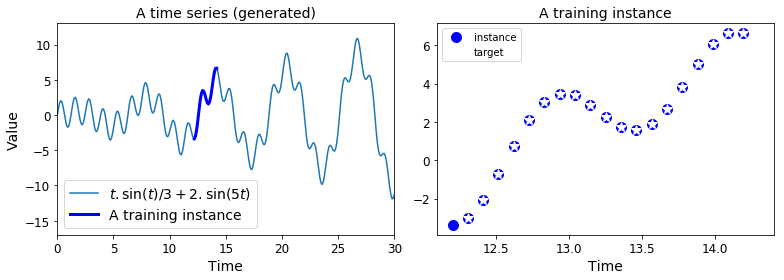

In [72]:

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [73]:
X_batch, y_batch = next_batch(1, n_steps)

In [74]:
np.c_[X_batch[0], y_batch[0]]

array([[-4.50341339, -4.14236382],
       [-4.14236382, -3.92870702],
       [-3.92870702, -4.0488651 ],
       [-4.0488651 , -4.59566362],
       [-4.59566362, -5.54426493],
       [-5.54426493, -6.75703201],
       [-6.75703201, -8.0161452 ],
       [-8.0161452 , -9.07599852],
       [-9.07599852, -9.72255772],
       [-9.72255772, -9.82515641],
       [-9.82515641, -9.36805638],
       [-9.36805638, -8.45405093],
       [-8.45405093, -7.27923294],
       [-7.27923294, -6.08510771],
       [-6.08510771, -5.09977511],
       [-5.09977511, -4.48258027],
       [-4.48258027, -4.28578062],
       [-4.28578062, -4.44260919],
       [-4.44260919, -4.78464929],
       [-4.78464929, -5.08425773]])

## Using an `OuputProjectionWrapper`

In [1]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

NameError: name 'reset_graph' is not defined